In [143]:
import pandas as pd
import seaborn as sns
import collections
sns.set()

In [114]:
data = pd.read_csv("exp_0001.csv", names=["MaxTries", "MaxNoImprov", "MaxIt", "NbCalls", "Metric"])
data["Metric"] = data.apply(lambda row: float(row["Metric"][:-2]), axis=1)
data.head()

MaxTries  MaxNoImprov  MaxIt  NbCalls    Metric
0       100            3    100      164  0.214427
1       100            3    100       32  0.377607
2       100            3    100      253  0.278587
3       100            3    100      106  0.311135
4       100            3    100      423  0.250052

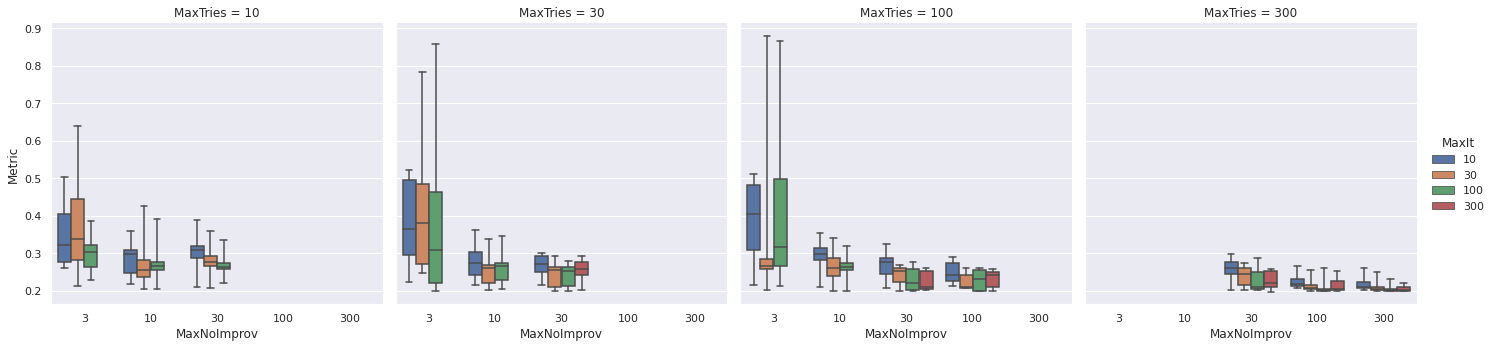

In [115]:
sns.catplot(data=data, kind='box', x="MaxNoImprov", y="Metric", hue="MaxIt", col="MaxTries", whis=100)

From the first data coming out of the experiment, one can see that no combination is consistently reliable.

There seem to be a very small variance for:
- MaxTries 30
- MaxNoImprox 10
- MaxIt 30

And unexpectedly good performance for 
- MaxTries 10
- MaxNoImprox 10
- MaxIt 100

As well as acceptable performance for
- MaxTries 100
- MaxNoImprov 10
- MaxIt 100

So I'll generate more data to see if this were flukes.

Also, MaxNoImprov = 3 is clearly way too low, as it is consistently bad. No need to repeat the experiment for this value.

For MaxNoImprov = 10, the worst case value is too high, so apart from the outliers mentioned above, we are not going to repeat the experiment for this value.

We are going to try higher values of MaxNoImprov (30, 100, 300), with the understanding tant MaxNoImprov > MaxTries is non-sensical.

MaxTries = 10 has a consistently bad worse case, no need to repeat the experiment either (except for the outlier mentioned above). So we start MaxTries at 30, and increase it to 100 then 300.

For MaxNoImprov = 30, Increading MaxIt seems to be reducing the variance. We'll add a new higer value for MaxIt to see if this effect plateaus.

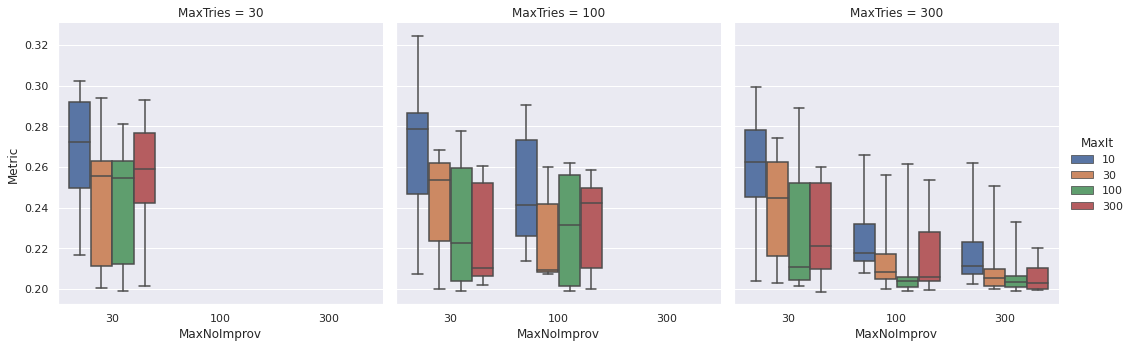

In [116]:
sns.catplot(data=data.query("MaxNoImprov > 10 and MaxTries > 10"),
            kind='box', x="MaxNoImprov", y="Metric", hue="MaxIt", col="MaxTries", whis=100)

When watching the thing run:
- When it converges, it converges quickly
- When it can't pack from the start, it uses up all MaxIt

Maybe we could get away with a huge MaxIt value (or even remove MaxIt all together) if we only used seed points for which one can pack.

We should also check that the slide packs at the origin (otherwise it will never pack).

There's a suspiciously narrow range of values for:
* MaxTries 300
* MaxNoImprov 100
* MaxIt 30 and 100


* MaxTries 300
* MaxNoImprov 300
* MaxIt 100 and 300

I'll do some reruns to see if it holds, or if its just a subsampling problem.

It seemed to be just a subsampling problem

<AxesSubplot:xlabel='NbCalls', ylabel='Metric'>

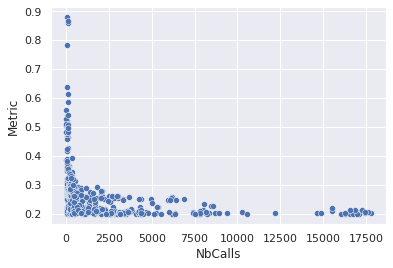

In [161]:
sns.scatterplot(data=data, x="NbCalls", y="Metric")

We want to be on the lower left of that figure: good performance, low number of calls.

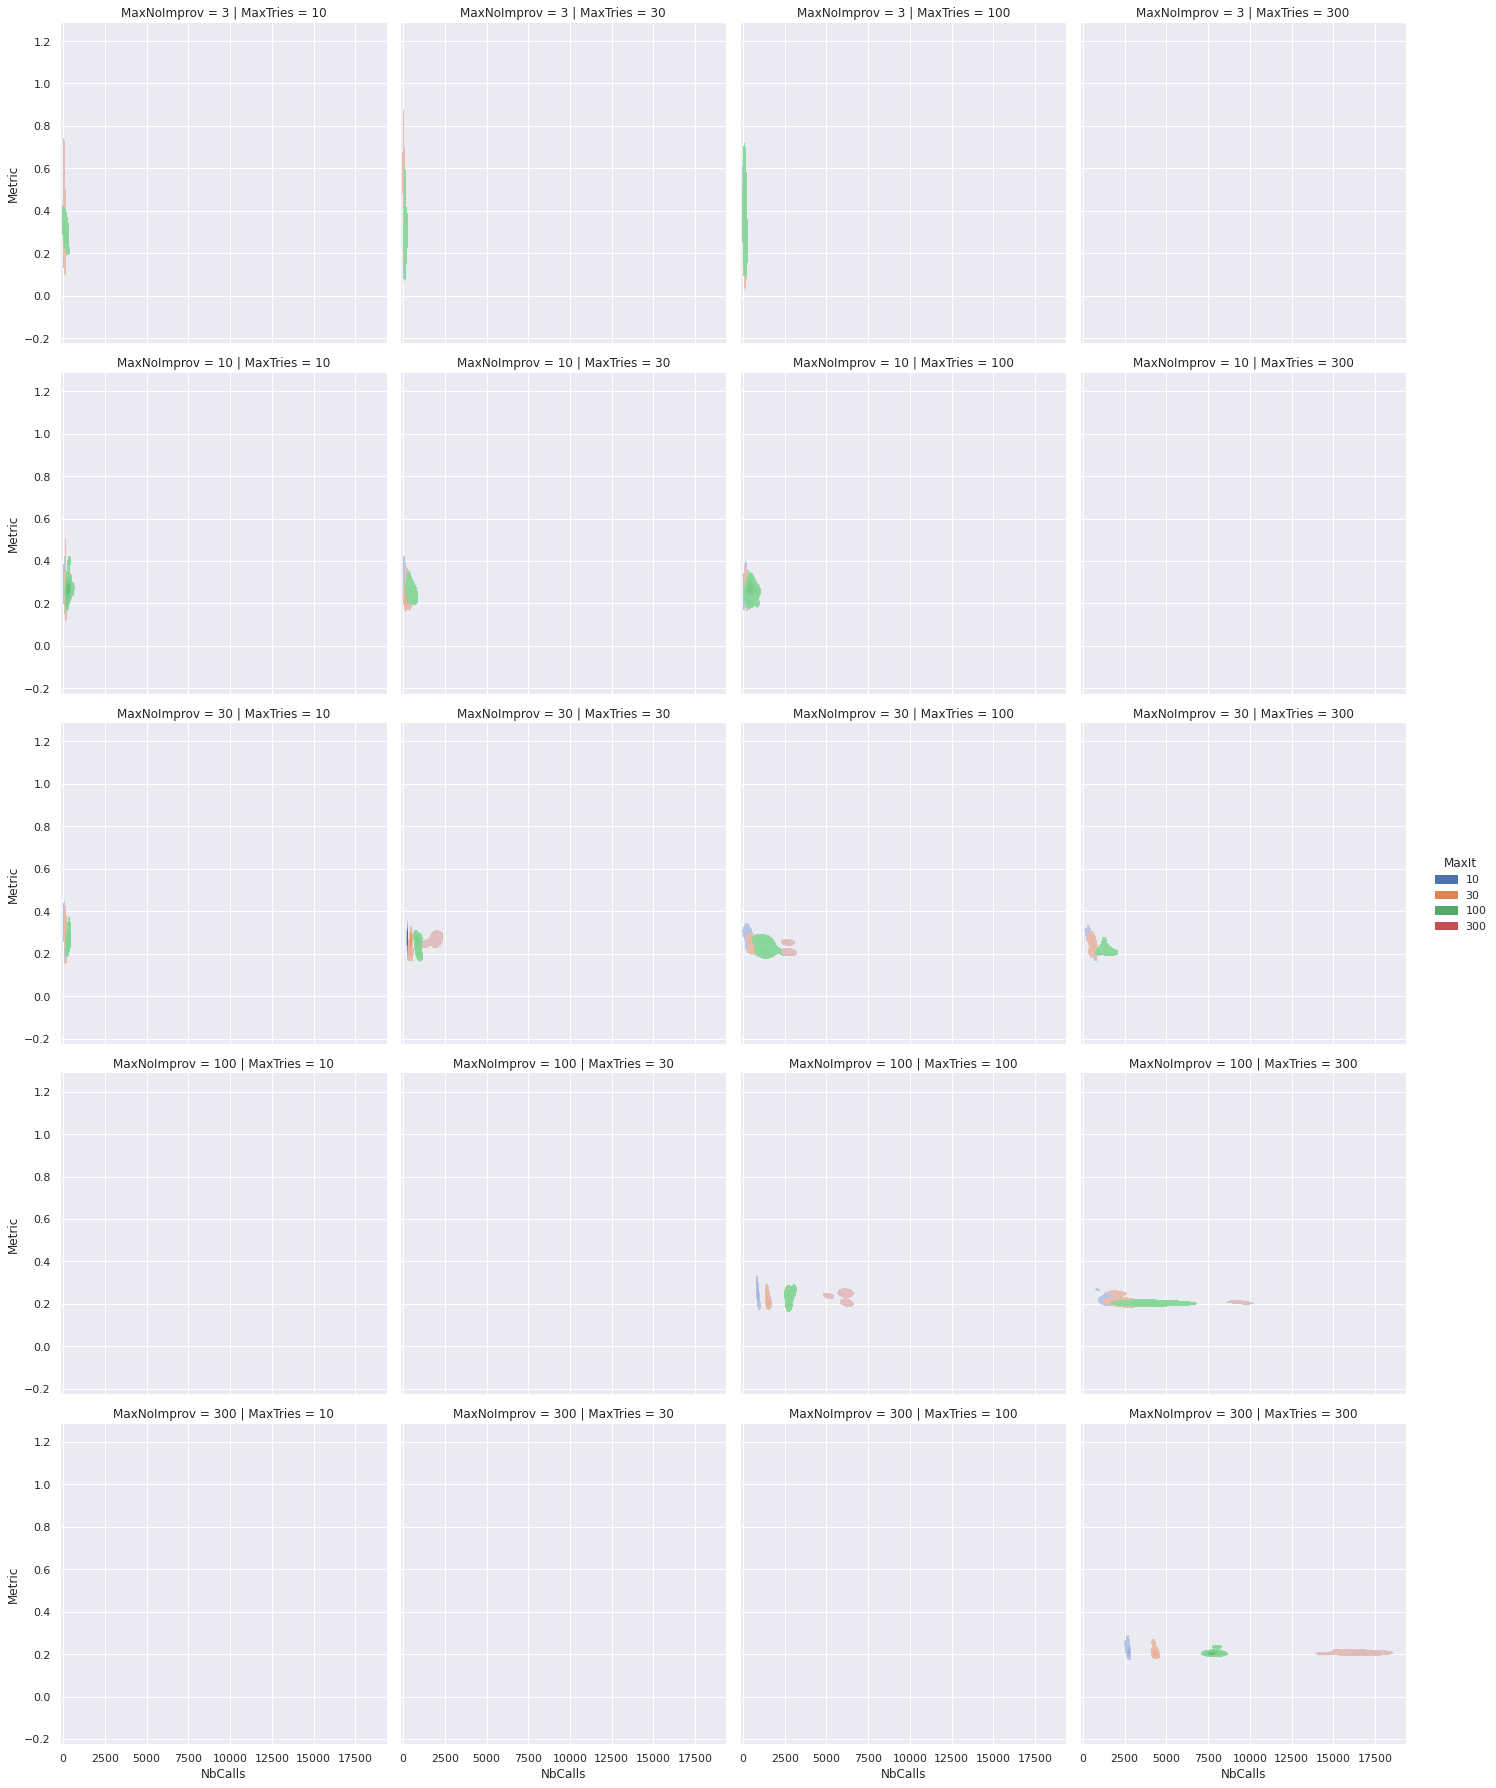

In [187]:
sns.displot(data= data.transform({k: str if k not in ["NbCalls", "Metric"] else lambda x:x for k in data.columns}, axis=0),
                 kind="kde", 
            col="MaxTries", col_order=["10", "30", "100", "300"],
            row="MaxNoImprov", x="NbCalls", y="Metric", fill=True,
            hue="MaxIt", hue_order=["10", "30", "100", "300"])

We see that we have three numbers that increase both performance and number of calls when they increase. Let's try to find the best compromise.

First let's restrict ourselves to all the consistently good methods. Let's remove the combinations of pramaeters whose worse case is over .3.


In [168]:
max_table = data.groupby(by=["MaxTries", "MaxNoImprov", "MaxIt"]).max().query("Metric <= .3")
max_table

NbCalls    Metric
MaxTries MaxNoImprov MaxIt                   
30       30          30         551  0.294121
                     100       1083  0.281089
                     300       2155  0.292903
100      30          30        1277  0.268365
                     100       2695  0.277661
                     300       4160  0.260600
         100         10         977  0.290658
                     30        1620  0.260083
                     100       3047  0.261728
                     300       6418  0.258478
300      30          10         668  0.299525
                     30         960  0.274425
                     100       2055  0.288882
                     300       5230  0.259792
         100         10        2129  0.266004
                     30        4365  0.256079
                     100       7858  0.261428
                     300      12171  0.253423
         300         10        2772  0.262155
                     30        4469  0.250686
                     100       8349  0.233107
                     300      17768  0.220249

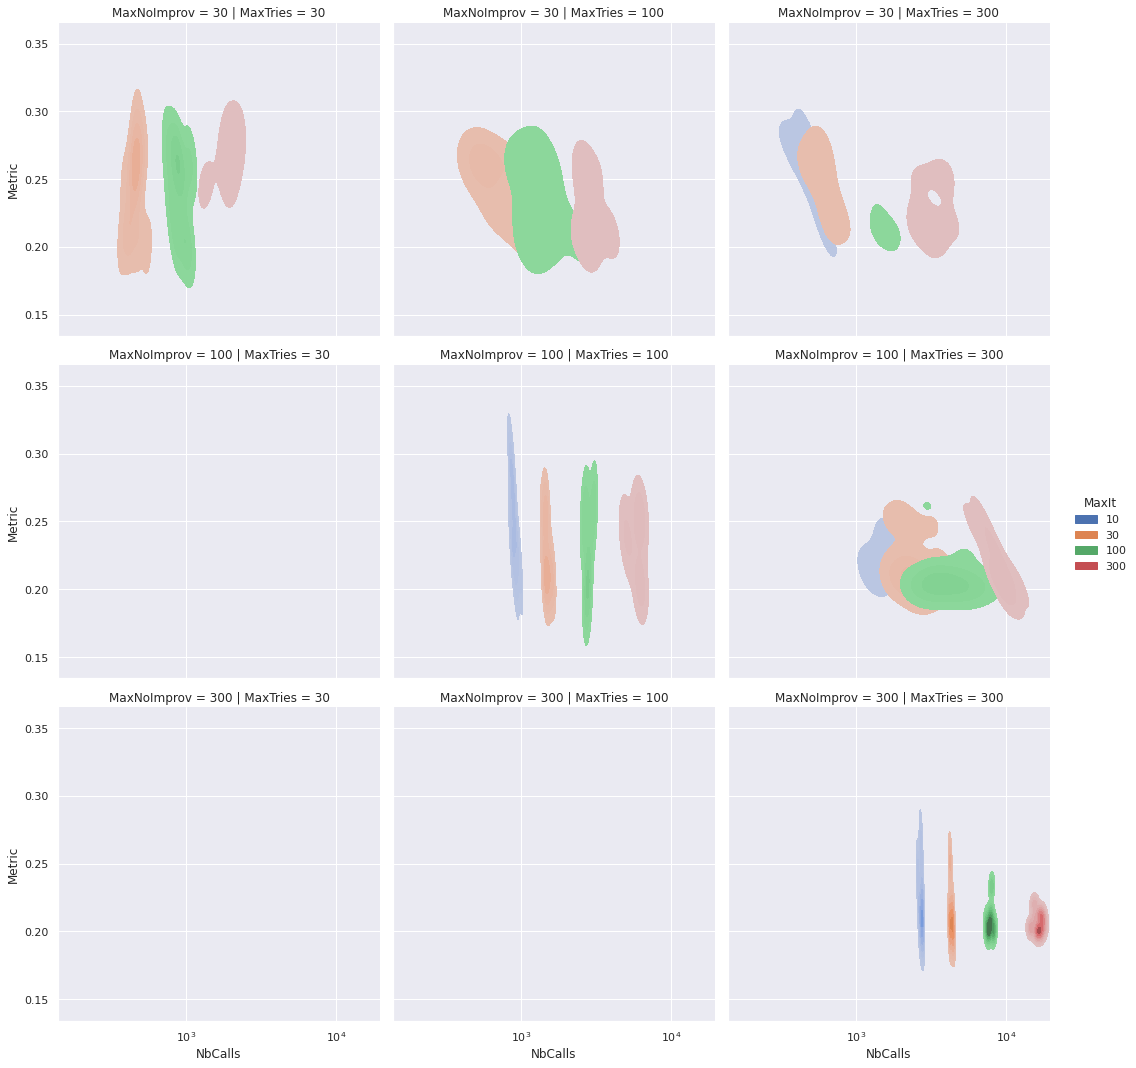

In [191]:
sns.displot(data=data[data.apply(lambda row: (row["MaxTries"], row["MaxNoImprov"], row["MaxIt"]) in max_table.index, axis=1)]\
            .transform({k: str if k not in ["NbCalls", "Metric"] else lambda x:x for k in data.columns}, axis=0),
              kind="kde", 
            col="MaxTries", col_order=["30", "100", "300"],
            row="MaxNoImprov", x="NbCalls", y="Metric", fill=True, 
            hue="MaxIt", hue_order=["10", "30", "100", "300"],
           log_scale=(True, False)
           )

MaxIt has a very clear effect on NbCalls, but a less clear effect on the quality of the solution, except when it's way too low (10).

Its goal was to limit the number of iterations done when the search does not converge, but maybe we can get rid of it.